***
The code, *"pcr_tool.py"*, contains a class of functions to help working with the PCRaster format to create a SPHY model input.<br>
In this notebook, we will demonstrate how to use these functions, particularly for conversions from/to other common data formats (numpy and xarray) and for visualizations.<br>
<br>
**NOTE**: If you are already familiar with the PCRaster format, you don't necessarily need to use the functions in this notbook. For more details on the PCRaster format, please see https://pcraster.geo.uu.nl/pcraster/4.4.1/documentation/index.html.
***

# 00. Load Packages

In [1]:
import os, glob
import pcraster as pcr
import pandas as pd
import xarray as xr
import rioxarray
import matplotlib.pyplot as plt
import cartopy.crs
import cartopy.io.img_tiles

import pcr_tool

# 01. Basic Inputs

In [2]:
epsg = 5266 # EPSG for clone.map - Bhutan National Grid: a transverse Mercator projection
epsg_check = 4326 # EPSG for checking projections - the common lat-lon coordinate reference system
missing_value = -9999 # missing_value to assign

path_clone = os.path.join('..', 'data', 'clone.map') # path to clone.map (example map 1)
path_dem = os.path.join('..', 'data', 'dem.map') # path to dem.map (example map 2)
path_tavg = glob.glob(os.path.join('..', 'data', 'tavg0000.00*')); path_tavg.sort() # a list of paths to tavg000.00*.map (example map 3)
tcoord = pd.date_range(start = pd.Timestamp('01/01/2006'), periods = len(path_tavg), freq = 'D') # set timestamps for tavg000.00*.map

path_out = os.path.join('..', 'scratch') # path for outputs
os.makedirs(path_out, exist_ok = True)

# 02. Clonemap

"Clonemap" is a pcraster map that defines a computationoal domain and its resolution using a bool (True/False) instance.<br>

First, we need to declare the class that we will be using throughout this notebook, with an EPSG to define a clonemap.

In [3]:
print(f'- Input EPSG:\n{epsg}')
map_clone = pcr_tool.clonemap(epsg = epsg)

- Input EPSG:
5266


Let's load a clonemap from a specified path on the class if you already have it.

In [4]:
print(f'- Input PCRaster Path:\n{path_clone}')
map_clone.load_clonemap(path = path_clone)

pcr.aguila(map_clone.clonemap) # plot

- Input PCRaster Path:
../data/clone.map


Or, we can create a clonemap based on the clonemap properties (number of rows and columns, cellsize, and west/north ends).

In [5]:
map_clone.create_clonemap(
    nrow = 280, # number of rows (x)
    ncol = 162, # number of columns (y)
    cellsize = 1000, # cell size (resolution)
    west = 126000, # coordinate for west boundary
    north = 3128000, # coordinate for north boundary
    )

pcr.aguila(map_clone.clonemap) # plot

# 03. Conversion between pcraster.Field and numpy.ndarray

Now, we're going to show conversion examples from pcraster.Field to numpy.ndarray.

In [6]:
# clone.map (example map 1)
ndarr_clone = map_clone.to_numpy() # 'field' is not required for clonemap

print('- Outputs:')
print(ndarr_clone)
print(ndarr_clone.shape)

- Outputs:
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
(280, 162)


In [7]:
# dem.map (example map 2)
print(f'- Input PCRaster Path:\n{path_dem}')
ndarr_dem = map_clone.to_numpy(field = path_dem)

print('- Outputs:')
print(ndarr_dem)
print(ndarr_dem.shape)

- Input PCRaster Path:
../data/dem.map
- Outputs:
[[  33.   35.   37. ...  359.  339.  306.]
 [  33.   38.   40. ...  357.  333.  281.]
 [  34.   40.   41. ...  330.  326.  306.]
 ...
 [5025. 4949. 4817. ... 5792. 5665. 5657.]
 [4887. 4779. 4738. ... 5789. 5631. 5458.]
 [4772. 4712. 4700. ... 5658. 5427. 5290.]]
(280, 162)


In [8]:
# tavg000.00*.map (example map 3)
print(f'- Input PCRaster Path (List):\n{path_tavg}')
ndarr_tavg = map_clone.to_numpy(field = path_tavg) # 'path_tavg' is a list of paths to represent a time dimension

print('- Outputs:')
print(ndarr_tavg)
print(ndarr_tavg.shape)

- Input PCRaster Path (List):
['../data/tavg0000.001', '../data/tavg0000.002', '../data/tavg0000.003']
- Outputs:
[[[ 17.9375  17.9375  17.9375 ...  17.9375  17.9375  17.9375]
  [ 17.9375  17.9375  17.9375 ...  17.9375  17.9375  17.9375]
  [ 17.9375  17.9375  17.9375 ...  17.9375  17.9375  17.9375]
  ...
  [-11.5625 -11.5625 -11.5625 ... -17.25   -17.25   -17.25  ]
  [-11.5625 -11.5625 -11.5625 ... -17.25   -17.25   -17.25  ]
  [-11.5625 -11.5625 -11.5625 ... -17.25   -17.25   -17.25  ]]

 [[ 17.625   17.625   17.625  ...  18.25    18.25    18.25  ]
  [ 17.625   17.625   17.625  ...  18.25    18.25    18.25  ]
  [ 17.625   17.625   17.625  ...  18.25    18.25    18.25  ]
  ...
  [ -9.9375  -9.9375  -9.9375 ... -17.5    -17.5    -17.5   ]
  [ -9.9375  -9.9375  -9.9375 ... -17.5    -17.5    -17.5   ]
  [ -9.9375  -9.9375  -9.9375 ... -17.5    -17.5    -17.5   ]]

 [[ 17.5     17.5     17.5    ...  18.5     18.5     18.5   ]
  [ 17.5     17.5     17.5    ...  18.5     18.5     18.5   ]
  

Let's check if the conversions back to pcraster.Field are identical to the orignals.<br>

Note: For the definitions of the pcratser data types, see https://pcraster.geo.uu.nl/pcraster/4.4.1/documentation/pcraster_manual/sphinx/secdatbase.html#maps-and-nonspatials

In [9]:
# clone.map (example map 1)
print(f'- Input numpy.ndarray:\n{ndarr_clone}')
map_clone_npconvs = map_clone.from_numpy(
    array = ndarr_clone, # numpy.ndarray to convert into pcraster.Field
    datatype = pcr.Boolean, # pcraster data type
    missing_value = missing_value, # missing value to assign
    )

print('- Outputs:')
print(map_clone_npconvs)
pcr.aguila(map_clone_npconvs) # plot the pcraster map that went through the conversions
pcr.aguila(path_clone) # plot the original pcrater map

- Input numpy.ndarray:
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
- Outputs:


In [10]:
# dem.map (example map 2)
print(f'- Input numpy.ndarray:\n{ndarr_dem}')
map_dem_npconvs = map_clone.from_numpy(
    array = ndarr_dem, # numpy.ndarray to convert into pcraster.Field
    datatype = pcr.Scalar, # pcraster data type
    missing_value = missing_value, # missing value to assign
    )

print('- Outputs:')
print(map_dem_npconvs)
pcr.aguila(map_dem_npconvs) # plot the pcraster map that went through the conversions
pcr.aguila(path_dem) # plot the original pcrater map

- Input numpy.ndarray:
[[  33.   35.   37. ...  359.  339.  306.]
 [  33.   38.   40. ...  357.  333.  281.]
 [  34.   40.   41. ...  330.  326.  306.]
 ...
 [5025. 4949. 4817. ... 5792. 5665. 5657.]
 [4887. 4779. 4738. ... 5789. 5631. 5458.]
 [4772. 4712. 4700. ... 5658. 5427. 5290.]]
- Outputs:


In [11]:
# tavg000.00*.map (example map 3)
print(f'- Input numpy.ndarray:\n{ndarr_tavg}')
idx_plot = 2
print(ndarr_tavg[idx_plot])
map_tavg_npconvs = map_clone.from_numpy(
    array = ndarr_tavg[idx_plot], # numpy.ndarray to convert into pcraster.Field
    datatype = pcr.Scalar, # pcraster data type
    missing_value = missing_value, # missing value to assign
    )

print('- Outputs:')
print(map_tavg_npconvs)
pcr.aguila(map_tavg_npconvs) # plot the pcraster map that went through the conversions
pcr.aguila(path_tavg[idx_plot]) # plot the original pcrater map

- Input numpy.ndarray:
[[[ 17.9375  17.9375  17.9375 ...  17.9375  17.9375  17.9375]
  [ 17.9375  17.9375  17.9375 ...  17.9375  17.9375  17.9375]
  [ 17.9375  17.9375  17.9375 ...  17.9375  17.9375  17.9375]
  ...
  [-11.5625 -11.5625 -11.5625 ... -17.25   -17.25   -17.25  ]
  [-11.5625 -11.5625 -11.5625 ... -17.25   -17.25   -17.25  ]
  [-11.5625 -11.5625 -11.5625 ... -17.25   -17.25   -17.25  ]]

 [[ 17.625   17.625   17.625  ...  18.25    18.25    18.25  ]
  [ 17.625   17.625   17.625  ...  18.25    18.25    18.25  ]
  [ 17.625   17.625   17.625  ...  18.25    18.25    18.25  ]
  ...
  [ -9.9375  -9.9375  -9.9375 ... -17.5    -17.5    -17.5   ]
  [ -9.9375  -9.9375  -9.9375 ... -17.5    -17.5    -17.5   ]
  [ -9.9375  -9.9375  -9.9375 ... -17.5    -17.5    -17.5   ]]

 [[ 17.5     17.5     17.5    ...  18.5     18.5     18.5   ]
  [ 17.5     17.5     17.5    ...  18.5     18.5     18.5   ]
  [ 17.5     17.5     17.5    ...  18.5     18.5     18.5   ]
  ...
  [ -8.8125  -8.8125  -8.

# 04. Conversion between pcraster.Field and xarray.DataArray

We're going to repeat the conversions of pcraster.Field, but now to/from xarray.DataArray.

In [12]:
# clone.map (example map 1)
da_clone = map_clone.to_xarray(varname = 'clone') # 'field' is not required for clonemap

print('- Outputs:')
print(da_clone)

- Outputs:
<xarray.DataArray 'clone' (y: 280, x: 162)>
array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)
Coordinates:
  * y        (y) float64 2.848e+06 2.85e+06 2.85e+06 ... 3.126e+06 3.128e+06
  * x        (x) float64 1.265e+05 1.275e+05 1.285e+05 ... 2.865e+05 2.875e+05


In [13]:
# dem.map (example map 2)
print(f'- Input PCRaster Path:\n{path_dem}')
da_dem = map_clone.to_xarray(
    field = path_dem, # pcraster.Field to convert into xarray.DataArray
    varname = 'dem', # variable name in xarray.DataArray
    )

print('- Outputs:')
print(da_dem)

- Input PCRaster Path:
../data/dem.map
- Outputs:
<xarray.DataArray 'dem' (y: 280, x: 162)>
array([[  33.,   35.,   37., ...,  359.,  339.,  306.],
       [  33.,   38.,   40., ...,  357.,  333.,  281.],
       [  34.,   40.,   41., ...,  330.,  326.,  306.],
       ...,
       [5025., 4949., 4817., ..., 5792., 5665., 5657.],
       [4887., 4779., 4738., ..., 5789., 5631., 5458.],
       [4772., 4712., 4700., ..., 5658., 5427., 5290.]], dtype=float32)
Coordinates:
  * y        (y) float64 2.848e+06 2.85e+06 2.85e+06 ... 3.126e+06 3.128e+06
  * x        (x) float64 1.265e+05 1.275e+05 1.285e+05 ... 2.865e+05 2.875e+05


In [14]:
# tavg000.00*.map (example map 3)
print(f'- Input PCRaster Path (List):\n{path_tavg}')
da_tavg = map_clone.to_xarray(
    field = path_tavg, # pcraster.Field to convert into xarray.DataArray
    tcoord = tcoord, # time index to assign in xarray.DataArray
    varname = 'tavg', # variable name in xarray.DataArray
    ) # as 'path_tavg' is a list of paths to represent a time dimension, 'tcoord' is set to assign for the time dimension

print('- Outputs:')
print(da_tavg)

- Input PCRaster Path (List):
['../data/tavg0000.001', '../data/tavg0000.002', '../data/tavg0000.003']
- Outputs:
<xarray.DataArray 'tavg' (time: 3, y: 280, x: 162)>
array([[[ 17.9375,  17.9375,  17.9375, ...,  17.9375,  17.9375,
          17.9375],
        [ 17.9375,  17.9375,  17.9375, ...,  17.9375,  17.9375,
          17.9375],
        [ 17.9375,  17.9375,  17.9375, ...,  17.9375,  17.9375,
          17.9375],
        ...,
        [-11.5625, -11.5625, -11.5625, ..., -17.25  , -17.25  ,
         -17.25  ],
        [-11.5625, -11.5625, -11.5625, ..., -17.25  , -17.25  ,
         -17.25  ],
        [-11.5625, -11.5625, -11.5625, ..., -17.25  , -17.25  ,
         -17.25  ]],

       [[ 17.625 ,  17.625 ,  17.625 , ...,  18.25  ,  18.25  ,
          18.25  ],
        [ 17.625 ,  17.625 ,  17.625 , ...,  18.25  ,  18.25  ,
          18.25  ],
        [ 17.625 ,  17.625 ,  17.625 , ...,  18.25  ,  18.25  ,
          18.25  ],
...
        [ -9.9375,  -9.9375,  -9.9375, ..., -17.5   , -17.5

Let's check if the conversions back to pcraster.Field are identical to the orignals.

In [15]:
# clone.map (example map 1)
print(f'- Input xarray.DataArray:\n{da_clone}')
map_clone_xrconvs = map_clone.from_xarray(
    dataarray = da_clone, # xarray.DataArray to convert into pcraster.Field
    datatype = pcr.Boolean, # pcraster data type
    missing_value = missing_value, # missing value to assign
    )

print('- Outputs:')
print(map_clone_xrconvs)
pcr.aguila(map_clone_xrconvs) # plot the pcraster map that went through the conversions
pcr.aguila(path_clone) # plot the original pcrater map

- Input xarray.DataArray:
<xarray.DataArray 'clone' (y: 280, x: 162)>
array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)
Coordinates:
  * y        (y) float64 2.848e+06 2.85e+06 2.85e+06 ... 3.126e+06 3.128e+06
  * x        (x) float64 1.265e+05 1.275e+05 1.285e+05 ... 2.865e+05 2.875e+05
- Outputs:


In [16]:
# dem.map (example map 2)
print(f'- Input xarray.DataArray:\n{da_dem}')
map_dem_xrconvs = map_clone.from_xarray(
    dataarray = da_dem, # xarray.DataArray to convert into pcraster.Field
    datatype = pcr.Scalar, # pcraster data type
    missing_value = missing_value, # missing value to assign
    )

print('- Outputs:')
print(map_dem_xrconvs)
pcr.aguila(map_dem_xrconvs) # plot the pcraster map that went through the conversions
pcr.aguila(path_dem) # plot the original pcrater map

- Input xarray.DataArray:
<xarray.DataArray 'dem' (y: 280, x: 162)>
array([[  33.,   35.,   37., ...,  359.,  339.,  306.],
       [  33.,   38.,   40., ...,  357.,  333.,  281.],
       [  34.,   40.,   41., ...,  330.,  326.,  306.],
       ...,
       [5025., 4949., 4817., ..., 5792., 5665., 5657.],
       [4887., 4779., 4738., ..., 5789., 5631., 5458.],
       [4772., 4712., 4700., ..., 5658., 5427., 5290.]], dtype=float32)
Coordinates:
  * y        (y) float64 2.848e+06 2.85e+06 2.85e+06 ... 3.126e+06 3.128e+06
  * x        (x) float64 1.265e+05 1.275e+05 1.285e+05 ... 2.865e+05 2.875e+05
- Outputs:


In [17]:
# tavg000.00*.map (example map 3)
print(f'- Input xarray.DataArray:\n{da_tavg}')
map_tavg_xrconvs = map_clone.from_xarray(
    dataarray = da_tavg, # xarray.DataArray to convert into pcraster.Field
    datatype = pcr.Scalar, # pcraster data type
    missing_value = missing_value, # missing value to assign
    )

print('- Outputs:')
print(map_tavg_xrconvs)

idx_plot = 2
pcr.aguila(map_tavg_xrconvs[idx_plot]) # plot the pcraster map that went through the conversions
pcr.aguila(path_tavg[idx_plot]) # plot the original pcrater map

- Input xarray.DataArray:
<xarray.DataArray 'tavg' (time: 3, y: 280, x: 162)>
array([[[ 17.9375,  17.9375,  17.9375, ...,  17.9375,  17.9375,
          17.9375],
        [ 17.9375,  17.9375,  17.9375, ...,  17.9375,  17.9375,
          17.9375],
        [ 17.9375,  17.9375,  17.9375, ...,  17.9375,  17.9375,
          17.9375],
        ...,
        [-11.5625, -11.5625, -11.5625, ..., -17.25  , -17.25  ,
         -17.25  ],
        [-11.5625, -11.5625, -11.5625, ..., -17.25  , -17.25  ,
         -17.25  ],
        [-11.5625, -11.5625, -11.5625, ..., -17.25  , -17.25  ,
         -17.25  ]],

       [[ 17.625 ,  17.625 ,  17.625 , ...,  18.25  ,  18.25  ,
          18.25  ],
        [ 17.625 ,  17.625 ,  17.625 , ...,  18.25  ,  18.25  ,
          18.25  ],
        [ 17.625 ,  17.625 ,  17.625 , ...,  18.25  ,  18.25  ,
          18.25  ],
...
        [ -9.9375,  -9.9375,  -9.9375, ..., -17.5   , -17.5   ,
         -17.5   ],
        [ -9.9375,  -9.9375,  -9.9375, ..., -17.5   , -17.5   ,

# 05. Export to PCRASTER/NETCDF/RASTER

We can export pcraster.Field into other formats with a different projection.

- Outputs:
write_pcraster - clone.map: written to ../scratch/clone.map.
write_netcdf: written to ../scratch/clone.nc.
write_raster: written to ../scratch/clone.tif.


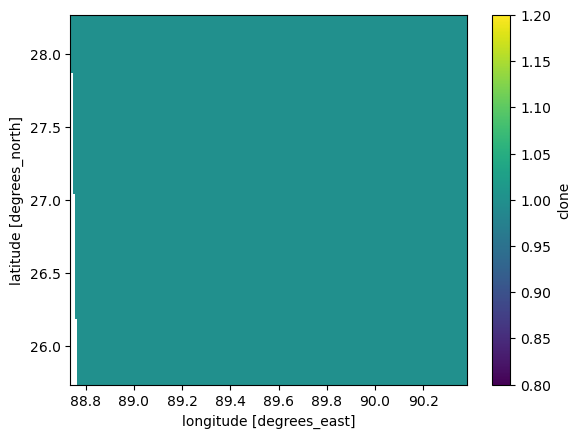

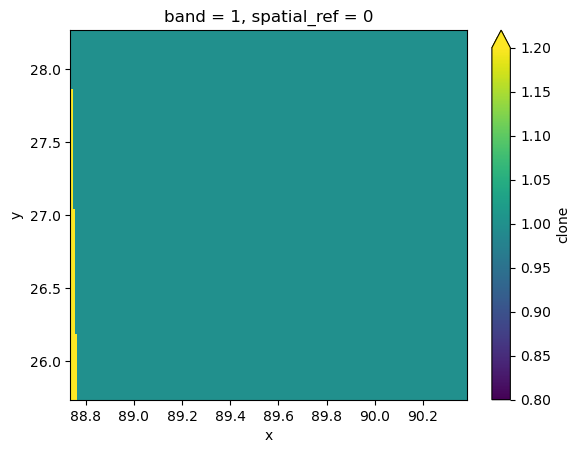

In [18]:
# clone.map (example map 1)
varname = 'clone'

print('- Outputs:')
map_clone.write_pcraster(path = os.path.join(path_out, 'clone.map')) # export into a pcratser file
# now, pass "epsg = epsg_check" to project into a different CRS (lat/lon)
map_clone.write_netcdf(
    path = os.path.join(path_out, 'clone.nc'), # path to write in the netcdf format
    varname = varname, # variable name to assign
    epsg = epsg_check, # output EPSG to project
    ) # export into a netcdf file
map_clone.write_raster(
    path = os.path.join(path_out, 'clone.tif'), # path to write in the geotiff format
    varname = varname, # variable name to assign
    epsg = epsg_check, # output EPSG to project
    ) # export into a geotiff file

pcr.aguila(os.path.join(path_out, 'clone.map')) # plot the pcratser file using the pcraster package
# plot the netcdf file using the xarray package
with xr.open_dataset(os.path.join(path_out, 'clone.nc')) as da:
    da[varname].plot(vmin = 0.8, vmax = 1.2)
    plt.show()
# plot the geotiff file using the rioxarray package
with rioxarray.open_rasterio(os.path.join(path_out, 'clone.tif')) as da_rio:
    da_rio.sel(band = 1).plot(vmin = 0.8, vmax = 1.2)
    plt.show()

- Outputs:
write_pcraster: written to ../scratch/dem.map.
write_netcdf: written to ../scratch/dem.nc.
write_raster: written to ../scratch/dem.tif.


/opt/miniconda3/envs/sphy/lib/python3.9/site-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


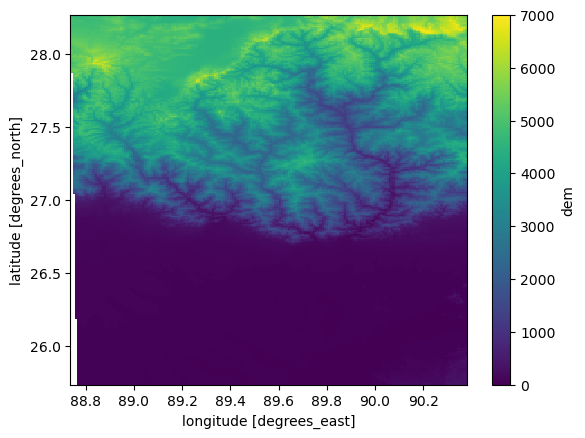

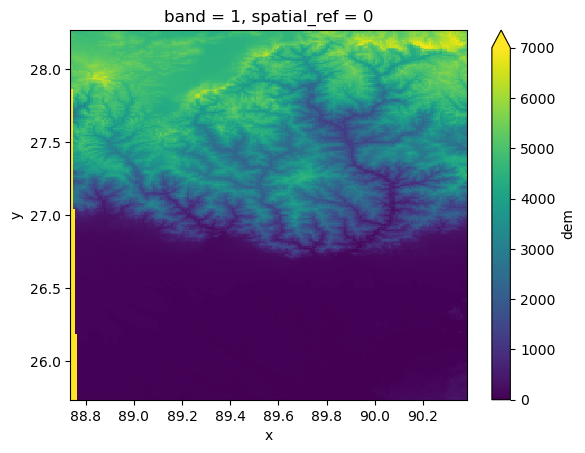

In [19]:
# dem.map (example map 2)
varname = 'dem'

print('- Outputs:')
map_clone.write_pcraster(
    path = os.path.join(path_out, 'dem.map'), # path to write in the pcraster format
    field = path_dem, # pcraster.Field to write
    ) # export into a pcratser file
# now, pass "epsg = epsg_check" to project into a different CRS (lat/lon)
map_clone.write_netcdf(
    path = os.path.join(path_out, 'dem.nc'), # path to write in the netcdf format
    field = path_dem, # pcraster.Field to write
    varname = varname, # variable name to assign
    epsg = epsg_check, # output EPSG to project
    ) # export into a netcdf file
map_clone.write_raster(
    path = os.path.join(path_out, 'dem.tif'), # path to write in the geotiff format
    field = path_dem, # pcraster.Field to write
    varname = varname, # variable name to assign
    epsg = epsg_check, # output EPSG to project
    ) # export into a geotiff file

pcr.aguila(os.path.join(path_out, 'dem.map')) # plot the pcratser file using the pcraster package
# plot the netcdf file using the xarray package
with xr.open_dataset(os.path.join(path_out, 'dem.nc')) as da:
    da[varname].plot(vmin = 0, vmax = 7000)
    plt.show()
# plot the geotiff file using the rioxarray package
with rioxarray.open_rasterio(os.path.join(path_out, 'dem.tif')) as da_rio:
    da_rio.sel(band = 1).plot(vmin = 0, vmax = 7000)
    plt.show()

- Outputs:
write_pcraster: written to ../scratch/tavg0000.001 - #1/3.
write_pcraster: written to ../scratch/tavg0000.002 - #2/3.
write_pcraster: written to ../scratch/tavg0000.003 - #3/3.
write_netcdf: written to ../scratch/tavg.nc.
write_raster: written to ../scratch/tavg0000.001.tif - #1/3.
write_raster: written to ../scratch/tavg0000.002.tif - #2/3.
write_raster: written to ../scratch/tavg0000.003.tif - #3/3.


/opt/miniconda3/envs/sphy/lib/python3.9/site-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


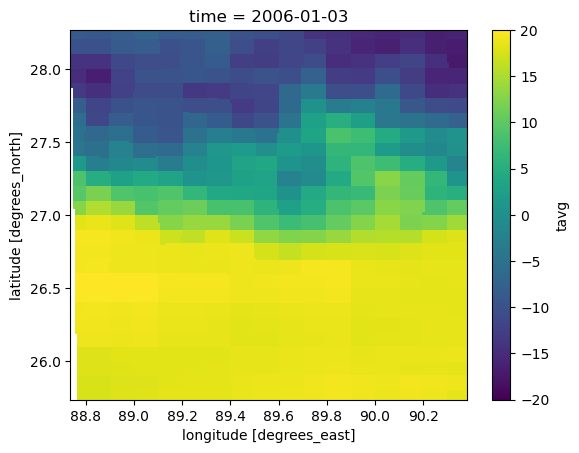

/opt/miniconda3/envs/sphy/lib/python3.9/site-packages/matplotlib/colors.py:732: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


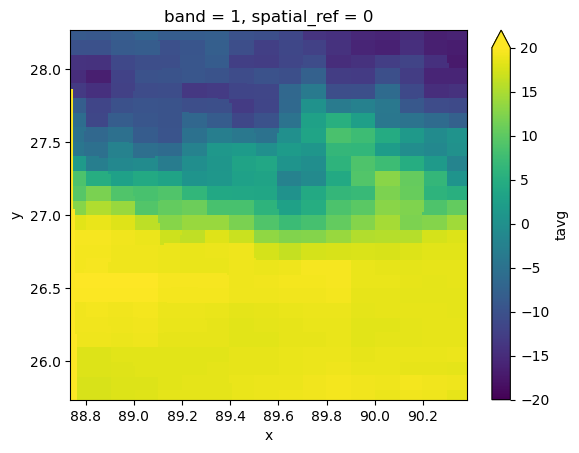

In [20]:
# tavg000.00*.map (example map 3)
varname = 'tavg'

print('- Outputs:')
map_clone.write_pcraster(
    path = [os.path.join(path_out, os.path.basename(p)) for p in path_tavg], # path to write in the pcraster format
    field = path_tavg, # pcraster.Field to write
    ) # export into the pcratser file
# now, pass "epsg = epsg_check" to project into a different CRS (lat/lon)
map_clone.write_netcdf(
    path = os.path.join(path_out, 'tavg.nc'), # path to write in the netcdf format
    field = path_tavg, # pcraster.Field to write
    tcoord = tcoord, # time index to write
    varname = varname, # variable name to assign
    epsg = epsg_check, # output EPSG to project
    ) # export into a netcdf file
map_clone.write_raster(
    path = [os.path.join(path_out, os.path.basename(p) + '.tif') for p in path_tavg], # path to write in the geotiff format
    field = path_tavg, # pcraster.Field to write
    tcoord = tcoord, # time index to write
    varname = varname, # variable name to assign
    epsg = epsg_check, # output EPSG to project
    ) # export into geotiff files

idx_plot = 2
pcr.aguila([os.path.join(path_out, os.path.basename(p)) for p in path_tavg][idx_plot]) # plot the pcratser file using the pcraster package
# plot the netcdf file using the xarray package
with xr.open_dataset(os.path.join(path_out, 'tavg.nc')) as da:
    da[varname].isel(time = idx_plot).plot(vmin = -20, vmax = 20)
    plt.show()
# plot the geotiff file using the rioxarray package
with rioxarray.open_rasterio([os.path.join(path_out, os.path.basename(p) + '.tif') for p in path_tavg][idx_plot]) as da_rio:
    da_rio.sel(band = 1).plot(vmin = -20, vmax = 20)
    plt.show()

# 06. Import from PCRASTER/NETCDF/RASTER

There are also functions to import from NETCDF/RASTER.

In [21]:
# clone.map (example map 1)
# pass "epsg = epsg_check" as the input files have a different CRS (lat/lon) now
map_clone_readnc = map_clone.read_netcdf(
    path = os.path.join(path_out, 'clone.nc'), # netcdf path to read
    varname = 'clone', # varable name to read
    epsg = epsg_check, # input EPSG
    datatype = pcr.Boolean, # pcraster data type
    xdim = 'x', # variable name of x-dimension
    ydim = 'y', # variable name of y-dimension
    ) # import from the netcdf file
map_clone_readrst = map_clone.read_raster(
    path = os.path.join(path_out, 'clone.tif'), # geotiff path to read
    epsg = epsg_check, # input EPSG
    datatype = pcr.Boolean, # pcraster data type
    band = 1 # band number to read
    ) # import from the geotiff file

print('- Outputs:')
print(map_clone_readnc)
print(map_clone_readrst)

# plots
pcr.aguila(map_clone_readnc)
pcr.aguila(map_clone_readrst)

- Outputs:


In [22]:
# dem.map (example map 2)
# pass "epsg = epsg_check" as the input files have a different CRS (lat/lon) now
map_dem_readnc = map_clone.read_netcdf(
    path = os.path.join(path_out, 'dem.nc'), # netcdf path to read
    varname = 'dem', # varable name to read
    epsg = epsg_check, # input EPSG
    datatype = pcr.Scalar, # pcraster data type
    xdim = 'x', # variable name of x-dimension
    ydim = 'y', # variable name of y-dimension
    ) # import from the netcdf file
map_dem_readrst = map_clone.read_raster(
    path = os.path.join(path_out, 'dem.tif'), # geotiff path to read
    epsg = epsg_check, # input EPSG
    datatype = pcr.Scalar, # pcraster data type
    band = 1, # band number to read
    ) # import from the geotiff file

print('- Outputs:')
print(map_dem_readnc)
print(map_dem_readrst)

# plots
pcr.aguila(map_dem_readnc)
pcr.aguila(map_dem_readrst)

- Outputs:


In [23]:
# tavg000.00*.map (example map 3)
# pass "epsg = epsg_check" as the input files have a different CRS (lat/lon) now
map_tavg_readnc = map_clone.read_netcdf(
    path = os.path.join(path_out, 'tavg.nc'), # netcdf path to read
    varname = 'tavg', # varable name to read
    epsg = epsg_check, # input EPSG
    datatype = pcr.Scalar, # pcraster data type
    xdim = 'x', # variable name of x-dimension
    ydim = 'y', # variable name of y-dimension
    tdim = 'time', # variable name of time-dimension
    tcoord = tcoord, # time index to read
    ) # import from the netcdf file
path_tif = glob.glob(os.path.join(path_out, 'tavg0000.00*.tif')); path_tif.sort() 
map_tavg_readrst = map_clone.read_raster(
    path = path_tif, # geotiff path to read
    epsg = epsg_check, # input EPSG
    datatype = pcr.Scalar, # pcraster data type
    band = 1, # band number to read
    ) # import from the geotiff files

print('- Outputs:')
print(map_tavg_readnc)
print(map_tavg_readrst)

# plots
idx_plot = 2
pcr.aguila(map_tavg_readnc[idx_plot])
pcr.aguila(map_tavg_readrst[idx_plot])

- Outputs:
[<pcraster._pcraster.Field object at 0x1692d7af0>, <pcraster._pcraster.Field object at 0x1692f48f0>, <pcraster._pcraster.Field object at 0x16929ae70>]
[<pcraster._pcraster.Field object at 0x1692fc1f0>, <pcraster._pcraster.Field object at 0x168c3c130>, <pcraster._pcraster.Field object at 0x1692aa4b0>]


We can extend these operations to generate forcing files from other datasets. Here, as an example, the GloH2O MSWX-Past dataset is used to generate forcing files.

In [24]:
n_day = 5 # generate forcing files for 5 days
path_forcing = os.path.join('..', 'data', 'FORCING', 'MSWX-Past_daily_subset_2002.nc')
print(f'- Input Path for Meteorological Forcing:\n{path_forcing}')

map_t2m_MSWXP = map_clone.read_netcdf(
    path = path_forcing, # netcdf path to read
    varname = 'air_temperature', # varable name to read
    epsg = epsg_check, # input EPSG
    datatype = pcr.Scalar, # pcraster data type
    xdim = 'lon', # variable name of x-dimension
    ydim = 'lat', # variable name of y-dimension
    tdim = 'time', # variable name of time-dimension
    tcoord = pd.date_range(start = pd.Timestamp('01/01/2002'), periods = n_day, freq = 'D'), # time index to read
    )

print('- Outputs:')
print(map_t2m_MSWXP)

# export into a pcraster file
map_clone.write_pcraster(
    path = [os.path.join(path_out, 'tair{:08.3f}'.format((1 + n) / 1000)) for n in range(n_day)], # path to write in the pcraster format
    field = map_t2m_MSWXP, # pcraster.Field to write
    )

# plot
idx_plot = 4
pcr.aguila(map_t2m_MSWXP[idx_plot])

- Input Path for Meteorological Forcing:
../data/FORCING/MSWX-Past_daily_subset_2002.nc
- Outputs:
[<pcraster._pcraster.Field object at 0x16923a770>, <pcraster._pcraster.Field object at 0x16931b0f0>, <pcraster._pcraster.Field object at 0x1692d7e30>, <pcraster._pcraster.Field object at 0x1692a7170>, <pcraster._pcraster.Field object at 0x168c35070>]
write_pcraster: written to ../scratch/tair0000.001 - #1/5.
write_pcraster: written to ../scratch/tair0000.002 - #2/5.
write_pcraster: written to ../scratch/tair0000.003 - #3/5.
write_pcraster: written to ../scratch/tair0000.004 - #4/5.
write_pcraster: written to ../scratch/tair0000.005 - #5/5.


# 07. Other Plotting Options

In addtion to pcraster.aguila, pcraster.plot can be used to plot through the matplotlib package.

- Input PCRaster Path:
../data/clone.map
- Outputs:


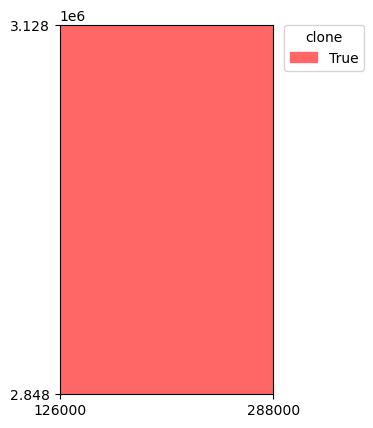

- Input PCRaster Path:
../data/dem.map
- Outputs:


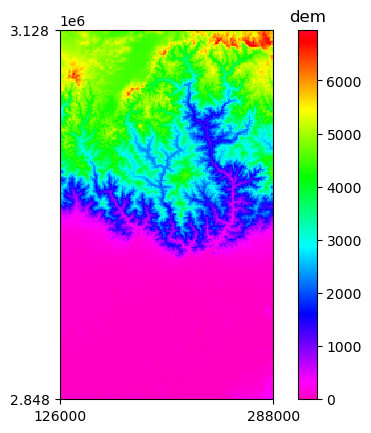

- Input PCRaster Path:
../data/tavg0000.003
- Outputs:


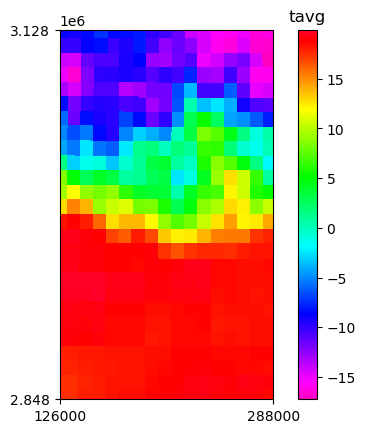

In [25]:
# clone.map (example map 1)
print(f'- Input PCRaster Path:\n{path_clone}')
print('- Outputs:')
pcr.plot(
    raster = pcr.readmap(path_clone), # pcraster.Field to plot
    labels = {1: 'True'}, # labels to show
    title = 'clone', # title to show
#    filename = os.path.join(path_out, 'clone.png'), # path to save the figure - currently, causing an error
    )

# dem.map (example map 2)
print(f'- Input PCRaster Path:\n{path_dem}')
print('- Outputs:')
pcr.plot(
    raster = pcr.readmap(path_dem), # pcraster.Field to plot
    title = 'dem', # title to show
    )

# tavg000.00*.map (example map 3)
idx_plot = 2
print(f'- Input PCRaster Path:\n{path_tavg[idx_plot]}')
print('- Outputs:')
pcr.plot(
    raster = pcr.readmap(path_tavg[idx_plot]), # pcraster.Field to plot
    title = 'tavg', # title to show
    )

Also, "pcr_tool.py" has a plot function based on the matplotlib and cartopy packages.

- Input PCRaster Path:
../data/clone.map
- Outputs:


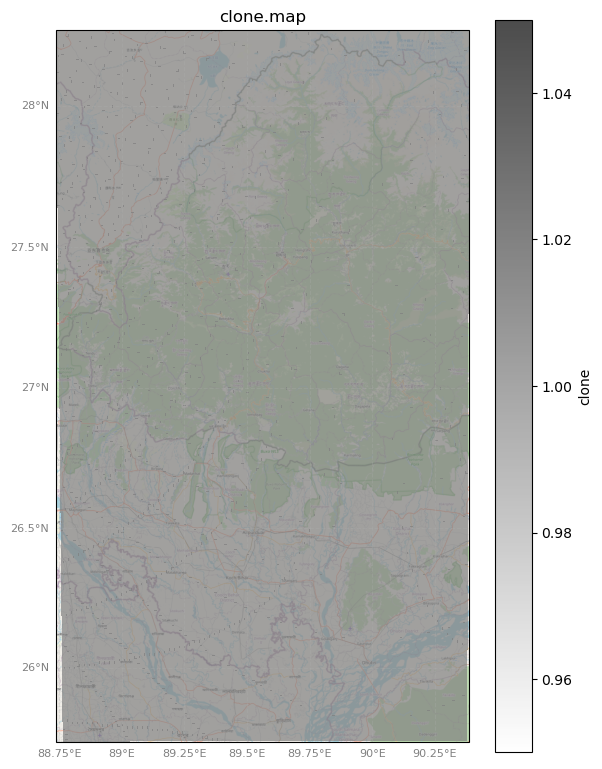

- Input PCRaster Path:
../data/dem.map
- Outputs:


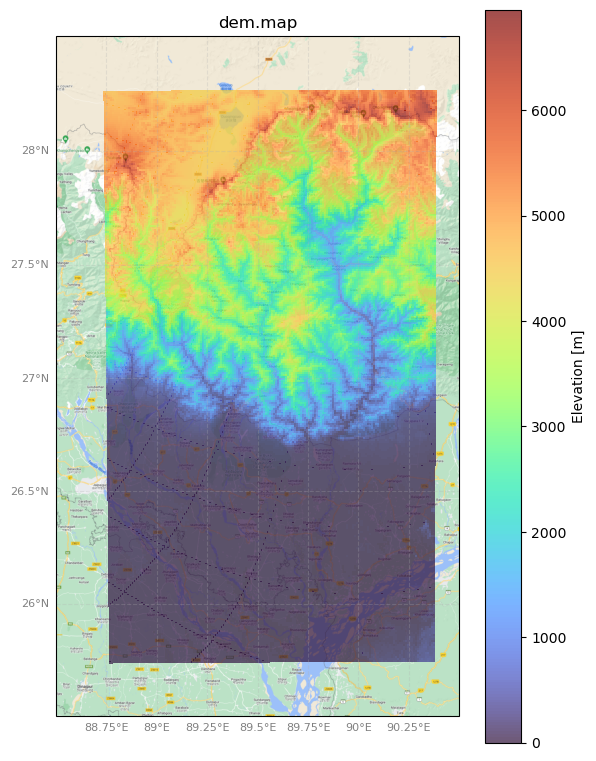

- Input PCRaster Path:
../data/tavg0000.003
- Outputs:


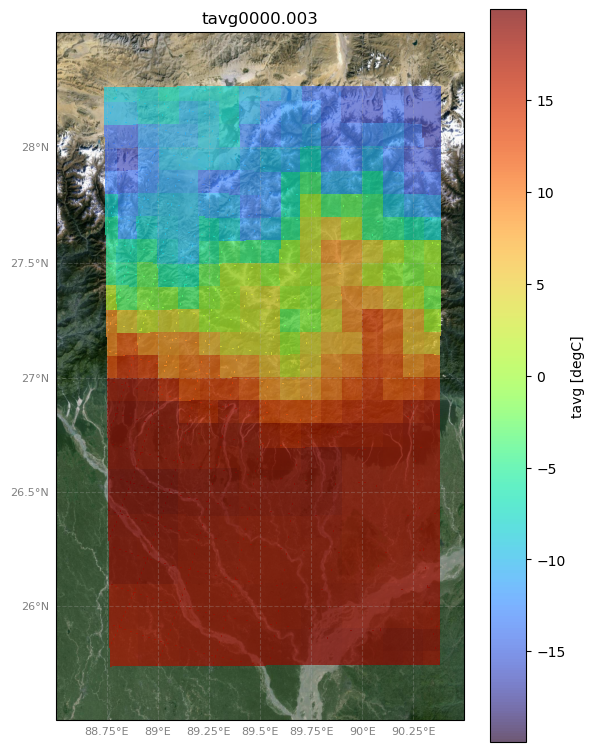

In [26]:
# clone.map (example map 1)
print(f'- Input PCRaster Path:\n{path_clone}')
print('- Outputs:')
map_clone.plot_cartopy(
    field = path_clone, # pcraster.Field to plot
    shapes = [], # a list of cartopy.feature.ShapelyFeature to plot together
    figsize = (6, 8), # matplotlib figure size
    basemap = cartopy.io.img_tiles.OSM(), # cartopy basemap (here, OpenStreetMap)
    basemap_level = 10, # cartopy basemap zoom level
    extent = None, # cartopy map extent
    vmin = None, # matplotlib contour min
    vmax = None, # matplotlib contour max
    cmap = 'binary', # matplotlib contour colormap
    alpha = 0.7, # matplotlib contour transparency
    title = 'clone.map', # matplotlib figure title
    clabel = 'clone', # matplotlib contour label
    savefig = None, # path to save the figure
    )

# dem.map (example map 2)
print(f'- Input PCRaster Path:\n{path_dem}')
print('- Outputs:')
map_clone.plot_cartopy(
    field = pcr.readmap(path_dem), # pcraster.Field to plot
    shapes = [], # a list of cartopy.feature.ShapelyFeature to plot together
    figsize = (6, 8), # matplotlib figure size
    basemap = cartopy.io.img_tiles.GoogleTiles(style = 'street'), # cartopy basemap (here, Google Satellite Images)
    basemap_level = 10, # cartopy basemap zoom level
    extent = [88.5, 90.5, 25.5, 28.5], # cartopy map extent
    vmin = None, # matplotlib contour min
    vmax = None, # matplotlib contour max
    cmap = 'turbo', # matplotlib contour colormap
    alpha = 0.7, # matplotlib contour transparency
    title = 'dem.map', # matplotlib figure title
    clabel = 'Elevation [m]', # matplotlib contour label
    savefig = None, # path to save the figure
    )

# tavg000.00*.map (example map 3)
idx_plot = 2
print(f'- Input PCRaster Path:\n{path_tavg[idx_plot]}')
print('- Outputs:')
map_clone.plot_cartopy(
    field = path_tavg, # pcraster.Field to plot
    idx_plot = idx_plot, # index to plot if field is a list
    shapes = [], # a list of cartopy.feature.ShapelyFeature to plot together
    figsize = (6, 8), # matplotlib figure size
    basemap = cartopy.io.img_tiles.GoogleTiles(style = 'satellite'), # cartopy basemap (here, Google Satellite Images)
    basemap_level = 10, # cartopy basemap zoom level
    extent = [88.5, 90.5, 25.5, 28.5], # cartopy map extent
    vmin = None, # matplotlib contour min
    vmax = None, # matplotlib contour max
    cmap = 'turbo', # matplotlib contour colormap
    alpha = 0.7, # matplotlib contour transparency
    title = os.path.basename(path_tavg[idx_plot]), # matplotlib figure title
    clabel = 'tavg [degC]', # matplotlib contour label
    savefig = None, # path to save the figure
    )